<a href="https://colab.research.google.com/github/Ivankarimov/My-first-ML-task/blob/main/Multiclassification_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch
from torch.utils.data import Dataset

In [2]:
df = pd.read_csv("public_data.csv")
df = df.dropna(subset=['Document', 'Topic_group'])
print(df['Topic_group'].value_counts())

Topic_group
Hardware                 11328
HR Support               10032
Access                    6627
Miscellaneous             6495
Storage                   2616
Purchase                  2447
Internal Project          2042
Administrative rights     1466
Name: count, dtype: int64


In [3]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Topic_group'])
labels = df['label'].tolist()

In [4]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Document'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(
    list(train_texts), truncation=True, padding=True, max_length=256
)
val_encodings = tokenizer(
    list(val_texts), truncation=True, padding=True, max_length=256
)
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: karimovivan70 (karimovivan70-mirea-russian-technological-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.446400,0.387025,0.872953,0.875747,0.872953,0.873264
2,0.281600,0.364928,0.885379,0.886422,0.885379,0.885631
3,0.142600,0.459526,0.892231,0.892359,0.892231,0.892168


TrainOutput(global_step=6459, training_loss=0.34261296094063726, metrics={'train_runtime': 4602.0214, 'train_samples_per_second': 22.452, 'train_steps_per_second': 1.404, 'total_flos': 1.3593838735171584e+16, 'train_loss': 0.34261296094063726, 'epoch': 3.0})

In [7]:
preds = trainer.predict(val_dataset).predictions.argmax(-1)
print(classification_report(val_labels, preds, target_names=label_encoder.classes_))

                       precision    recall  f1-score   support

               Access       0.92      0.94      0.93      1326
Administrative rights       0.82      0.83      0.82       293
           HR Support       0.90      0.90      0.90      2007
             Hardware       0.89      0.87      0.88      2266
     Internal Project       0.89      0.84      0.86       408
        Miscellaneous       0.86      0.88      0.87      1299
             Purchase       0.95      0.91      0.93       489
              Storage       0.91      0.93      0.92       523

             accuracy                           0.89      8611
            macro avg       0.89      0.89      0.89      8611
         weighted avg       0.89      0.89      0.89      8611



In [8]:
# Сохраняем модель
model.save_pretrained("bert_topic_model")

# Сохраняем токенизатор
tokenizer.save_pretrained("bert_topic_model")

('bert_topic_model/tokenizer_config.json',
 'bert_topic_model/special_tokens_map.json',
 'bert_topic_model/vocab.txt',
 'bert_topic_model/added_tokens.json')

In [9]:
import joblib
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [10]:
!zip -r bert_model_package.zip bert_topic_model label_encoder.pkl
from google.colab import files
files.download("bert_model_package.zip")

  adding: bert_topic_model/ (stored 0%)
  adding: bert_topic_model/model.safetensors (deflated 7%)
  adding: bert_topic_model/vocab.txt (deflated 53%)
  adding: bert_topic_model/tokenizer_config.json (deflated 75%)
  adding: bert_topic_model/special_tokens_map.json (deflated 42%)
  adding: bert_topic_model/config.json (deflated 56%)
  adding: label_encoder.pkl (deflated 28%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

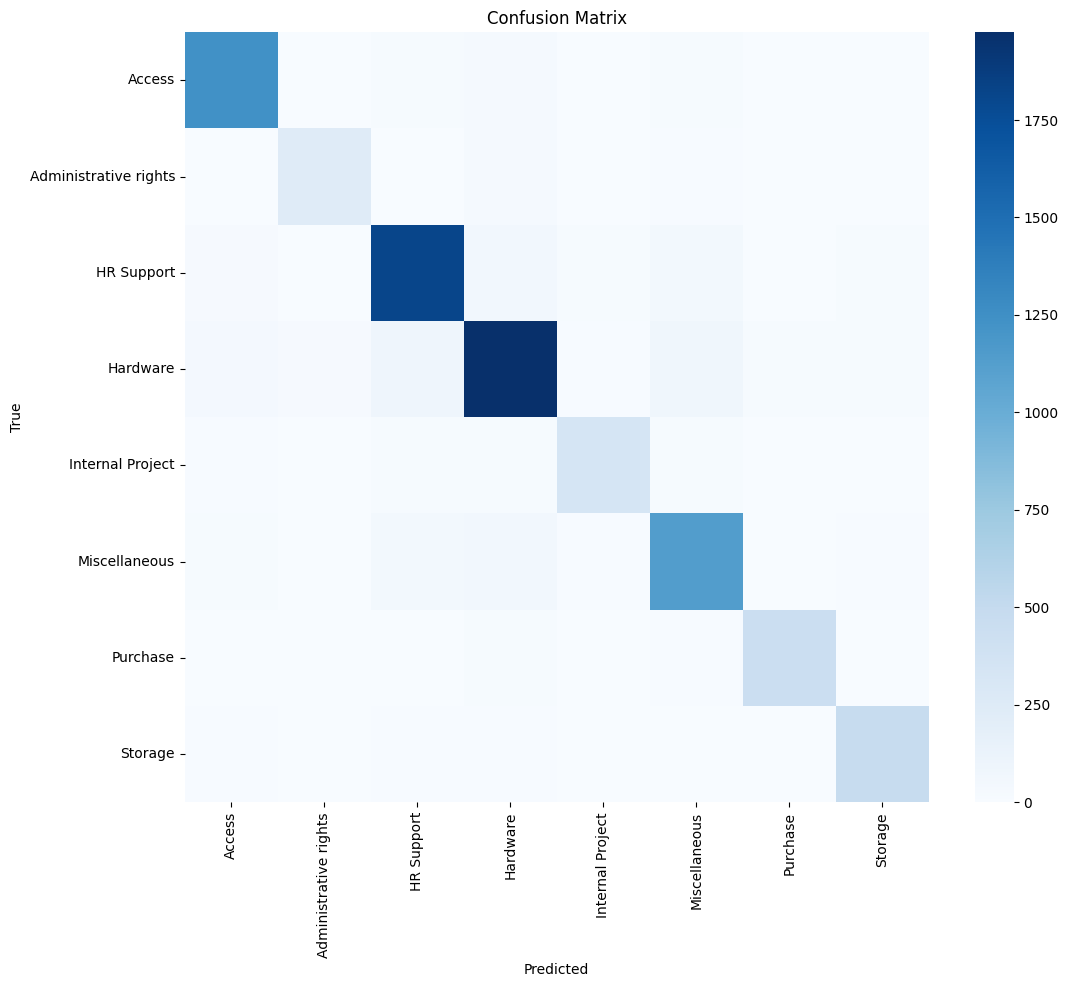

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()